In [1]:
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
from MMTModules import *
from DetectorTimeConstantModules import *

### 1D Calculation

The finite response of a detector in the time domain is exponential decay ($a(t) = e^{-t/\tau}$), where t=0 is when the detector 'sees' the signal and $\tau$ is the detector's time constant. This can be represented in the spatial domain by introducing a scan speed as a unit conversion ($e^{-\theta/(s\tau)}$). Given this spatial representation of the detector response function, this can be transformed to $\ell$-space through fourier transforming

$$a(k) = \int _{-\infty}^\infty e^{-\frac{\theta}{s\tau}} e^{-ik\theta}d\theta$$

This can be found to be a Lorentzian

$$a(k) = \frac{1}{\pi}\frac{k_0}{k_0^2+k^2}$$

and the relation between k and $\ell$ needs to be established

In the limit that a cross linking scan strategy is perfect, the exponential response function radially in 2D space. For a rastering scan strategy, the response function need only be applied along the direction of scan, only affecting the k-modes along the scan. This should mean that the 1D radial model should be equivalent to the 2D model applied to both axes, which can serve as a sanity check on the pipeline without the model. 

The fourier transform of the response function should look like a lowpass filter (normalized):

$$a(\ell) = \frac{1}{1 + \frac{\ell^2}{\ell_{cutoff}^2}}$$

This analytical form is not exact because it does not take into account the pixel window function, which will cause boundary effects for fast time constants. This presumption is checked below by increasing tau and watching the fit get better:

Parameter values are [0.43292807 3.14159173]


Text(0, 0.5, 'Magnitude (arb)')

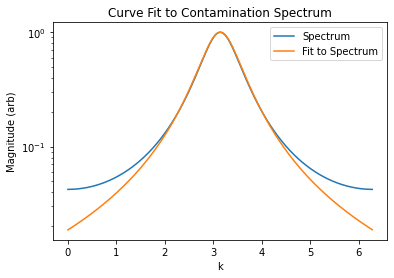

In [2]:
#define relevant constants
N = 1024  # []: pixels in map
pixel_size = 0.25  # [arcmin/pixel]: size in arcmin of pixel
ell_max = 5000  # [ell]: maximum ell
delta_ell = 50  # [ell]: bin width for power spectra
perc_err = 0.05  #[%]: percent the measure is off by
scan_sp = 1.  # [deg/s]: scan speed of telescope
tau = 10e-3  # [s]: time constant of detector
ell = np.arange(ell_max)  # [ell]: array of ell
L = N*pixel_size

##########################################################################################################

#setup exponential decay in position space
x = (np.arange(N)/N -0.5)*L
exp_decay_1d = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*60.))

#take fft
exp_decay_1d_fft = np.fft.fftshift(np.fft.fft(exp_decay_1d))

exp_decay_1d_fft = np.sqrt(np.real(np.conj(exp_decay_1d_fft)*exp_decay_1d_fft))

#calculate the fourier modes
freqs_array = np.zeros(N)
k_array = np.arange(N)
for i in range(N):
    k = k_array[i]
    freqs_array[i] = 2*np.pi/N*k
    


####################################################################################################

#curve fit with offset lorentzian
def offset_lorentzian(x, xp, x0):
    return 1 / ( 1 + ((x-x0)/xp)**2. )

import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = freqs_array
initial_guess = np.array([1,3.2])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(exp_decay_1d_fft/np.max(exp_decay_1d_fft)))
errors = sigma*np.ones(len(exp_decay_1d_fft))
curve_fit = optimization.curve_fit(offset_lorentzian, ell_set, exp_decay_1d_fft/np.max(exp_decay_1d_fft), initial_guess, errors)

parameters = curve_fit[0]
tf_fit_r = offset_lorentzian(freqs_array,parameters[0],parameters[1])
print('Parameter values are ' + str(parameters))
plt.semilogy(freqs_array,exp_decay_1d_fft/np.max(exp_decay_1d_fft))
plt.semilogy(freqs_array, tf_fit_r/np.max(tf_fit_r))
plt.title('Curve Fit to Contamination Spectrum')
plt.legend(['Spectrum','Fit to Spectrum'])
plt.xlabel('k')
plt.ylabel('Magnitude (arb)')


2D Numerical Simulation

- Radial Smearing

- Preferred Scan Direction

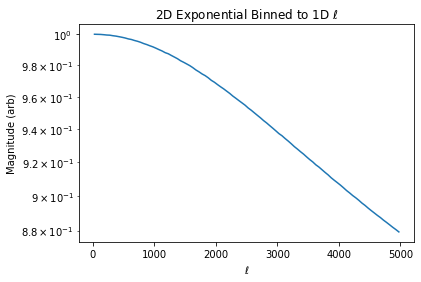

In [6]:
#define relevant constants
N = 1024  # []: pixels in map
pixel_size = 0.25  # [arcmin/pixel]: size in arcmin of pixel
ell_max = 5000  # [ell]: maximum ell
delta_ell = 50  # [ell]: bin width for power spectra
perc_err = 0.05  #[%]: percent the measure is off by
scan_sp = 1.  # [deg/s]: scan speed of telescope
tau = 10e-3  # [s]: time constant of detector
ell = np.arange(ell_max)  # [ell]: array of ell
L = N*pixel_size

#define 2D model
##define 2D coordinate system in map space
x_1d = (np.arange(N)/N - 0.5)*L*np.pi/(180.*60.)
y_1d = np.copy(x_1d)
x,y = np.meshgrid(x_1d,y_1d)

r = np.sqrt(x**2. + y**2.)
exp_decay_2d = np.exp(-r/(scan_sp*tau*np.pi/180.))
exp_decay_2d_meas = np.exp(-r/(scan_sp*tau*np.pi/180.*(1-perc_err)))

#take fft's and deconvolve
exp_decay_2d_fft = np.fft.fftshift(np.fft.fft2(exp_decay_2d))
exp_decay_2d_meas_fft = np.fft.fftshift(np.fft.fft2(exp_decay_2d_meas))
exp_decay_2d_res_fft = np.zeros((N,N),dtype=complex)

exp_decay_2d_res_fft = exp_decay_2d_fft / exp_decay_2d_meas_fft

#for posterity, this works here for radial but not if there's a preferred scan direction
#for i in range(N):
#    for j in range(N):
#        if exp_decay_2d_meas_fft[i,j] == 0. + 0*1j:
#            exp_decay_2d_res_fft[i,j] = 0. + 0*1j
#        else:
#            exp_decay_2d_res_fft[i,j] = exp_decay_2d_fft[i,j] / exp_decay_2d_meas_fft[i,j]


#bin to 1d
#exp_decay_2d_deproj_fft = np.fft.fftshift(np.fft.fft2((exp_decay_2d_deproj)))
maps_dict = {}
maps_dict['TT'] = exp_decay_2d_res_fft#/exp_decay_2d_deproj_fft
binned_ell, binned_exp_decay_2d_res = bin_maps_to_1d(maps_dict, delta_ell=delta_ell, ell_max=ell_max, pix_size=pixel_size, N=N)

#normalize
binned_exp_decay_2d_res['TT'] = binned_exp_decay_2d_res['TT'] / np.max(binned_exp_decay_2d_res['TT'])

#plot
plt.semilogy(binned_ell, binned_exp_decay_2d_res['TT'])
plt.title('2D Exponential Binned to 1D $\ell$')
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')
plt.show()

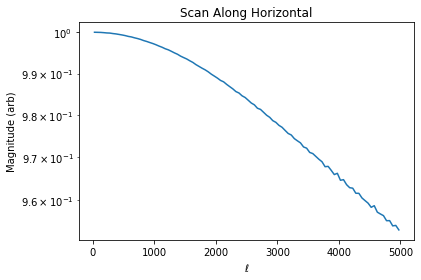

In [3]:
#define relevant constants
N = 1024  # []: pixels in map
pixel_size = 0.25  # [arcmin/pixel]: size in arcmin of pixel
ell_max = 5000  # [ell]: maximum ell
delta_ell = 50  # [ell]: bin width for power spectra
perc_err = 0.05  #[%]: percent the measure is off by
scan_sp = 1.  # [deg/s]: scan speed of telescope
tau = 10e-3  # [s]: time constant of detector
ell = np.arange(ell_max)  # [ell]: array of ell
L = N*pixel_size

#############################################################################

#define 2D model
##define 2D coordinate system in map space
x_1d = (np.arange(N)/N - 0.5)*L*np.pi/(180.*60.)
y_1d = np.copy(x_1d)
x,y = np.meshgrid(x_1d,y_1d)

exp_decay_2d_scanx = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*np.pi/180.))
exp_decay_2d_scanx_meas = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*np.pi/180.*(1-perc_err)))

#take fft of horizontal rows (scan axis)
exp_decay_2d_scanx_res_fft = np.zeros((N,N), dtype=complex)
for row in range(N):
    real_fft = np.fft.fftshift(np.fft.fft(exp_decay_2d_scanx[row,:]))
    meas_fft = np.fft.fftshift(np.fft.fft(exp_decay_2d_scanx_meas[row,:]))
    exp_decay_2d_scanx_res_fft[row,:] = real_fft / meas_fft


#bin to 1D PS
#exp_decay_2d_deproj_fft = np.fft.fftshift(np.fft.fft2((exp_decay_2d_deproj)))
maps_dict = {}
maps_dict['TT'] = exp_decay_2d_scanx_res_fft
binned_ell, binned_exp_decay_2d_scanx_res = bin_maps_to_1d(maps_dict, delta_ell=delta_ell, ell_max=ell_max, pix_size=pixel_size, N=N)

#normalize
binned_exp_decay_2d_scanx_res = binned_exp_decay_2d_scanx_res['TT'] / np.max(binned_exp_decay_2d_scanx_res['TT'])

#plot
plt.semilogy(binned_ell, binned_exp_decay_2d_scanx_res)
plt.title('Scan Along Horizontal')
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')
plt.show()


Text(0, 0.5, 'Magnitude (arb)')

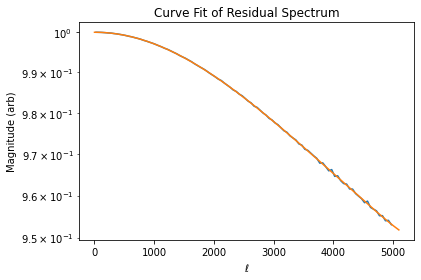

In [5]:
#define 9th order polynomial
def polynomial_9(x, a, b, c, d, e, f, g, h, i, j):
    return a*x**9. + b*x**8. + c*x**7. + d*x**6. + e*x**5. + f*x**4. + g*x**3. + h*x**2. + i*x + j

#For TE
import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = binned_ell
initial_guess = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(binned_exp_decay_2d_scanx_res))
errors = sigma*np.ones(len(binned_exp_decay_2d_scanx_res))
curve_fit = optimization.curve_fit(polynomial_9, ell_set, binned_exp_decay_2d_scanx_res, initial_guess, errors)

parameters = curve_fit[0]
ell = np.arange(ell_max+101)
tf_fit = polynomial_9(ell,parameters[0],parameters[1],parameters[2],
                      parameters[3],parameters[4],parameters[5],
                      parameters[6],parameters[7],parameters[8],parameters[9])
plt.semilogy(binned_ell,binned_exp_decay_2d_scanx_res)
plt.semilogy(ell,tf_fit)
plt.title('Curve Fit of Residual Spectrum')
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')

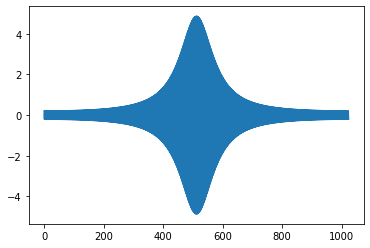

In [4]:
row_fft = np.fft.fftshift(np.fft.fft(exp_decay_2d_scanx[512,:]))
plt.plot(np.real(row_fft))
plt.show()

Compare to Radial Smear

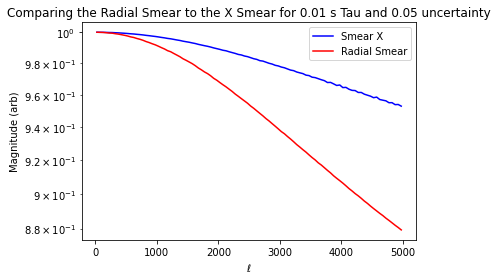

In [7]:
plt.semilogy(binned_ell, binned_exp_decay_2d_scanx_res,color='b')
plt.semilogy(binned_ell, binned_exp_decay_2d_res['TT'],color='r')
plt.legend(['Smear X','Radial Smear'])
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')
plt.title('Comparing the Radial Smear to the X Smear for %s s Tau and %s uncertainty'%(tau,perc_err))
plt.show()

There appears to be some noise in the anisotropic smear that seems to increase by making the leakage worse (i.e. increasing the time constant or increasing the measurement uncertainty). This could be mitigated by fitting the noisy spectrum to a polynomial. An illustration is below

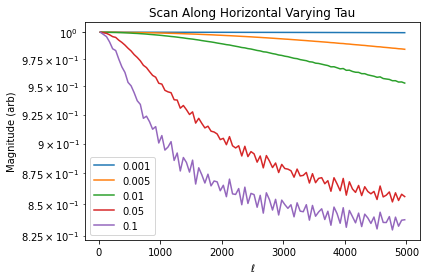

In [81]:
tau_set = [1e-3,5e-3,10e-3,50e-3,100e-3]
perc_err = 0.05

#define relevant constants
N = 1024  # []: pixels in map
pixel_size = 0.25  # [arcmin/pixel]: size in arcmin of pixel
ell_max = 5000  # [ell]: maximum ell
delta_ell = 50  # [ell]: bin width for power spectra
scan_sp = 1.  # [deg/s]: scan speed of telescope
ell = np.arange(ell_max)  # [ell]: array of ell
L = N*pixel_size

#############################################################################

#define 2D model
##define 2D coordinate system in map space
x_1d = (np.arange(N)/N - 0.5)*L*np.pi/(180.*60.)
y_1d = np.copy(x_1d)
x,y = np.meshgrid(x_1d,y_1d)

binned_exp_decay_2d_scanx_tau_set = np.zeros((len(tau_set),int(ell_max/delta_ell)))
for tau in tau_set:
    exp_decay_2d_scanx = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*np.pi/180.))
    exp_decay_2d_scanx_meas = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*np.pi/180.*(1-perc_err)))

    #take fft's and deconvolve
    exp_decay_2d_scanx_fft = np.fft.fftshift(np.fft.fft2(exp_decay_2d_scanx))
    exp_decay_2d_scanx_meas_fft = np.fft.fftshift(np.fft.fft2(exp_decay_2d_scanx_meas))
    exp_decay_2d_scanx_res_fft = np.zeros((N,N),dtype=complex)

    exp_decay_2d_scanx_res_fft[512,:] = exp_decay_2d_scanx_fft[512,:] / exp_decay_2d_scanx_meas_fft[512,:]
    for row in range(N):
        exp_decay_2d_scanx_res_fft[row,:] = exp_decay_2d_scanx_fft[512,:] / exp_decay_2d_scanx_meas_fft[512,:]

    #bin to 1d PS
    #exp_decay_2d_deproj_fft = np.fft.fftshift(np.fft.fft2((exp_decay_2d_deproj)))
    maps_dict = {}
    maps_dict['TT'] = exp_decay_2d_scanx_res_fft
    binned_ell, binned_exp_decay_2d_scanx_res = bin_maps_to_1d(maps_dict, delta_ell=delta_ell, ell_max=ell_max, pix_size=pixel_size, N=N)

    #normalize
    binned_exp_decay_2d_scanx_res['TT'] = binned_exp_decay_2d_scanx_res['TT'] / np.max(binned_exp_decay_2d_scanx_res['TT'])

    #plot
    plt.semilogy(binned_ell, binned_exp_decay_2d_scanx_res['TT'])
    
plt.title('Scan Along Horizontal Varying Tau')
plt.legend(tau_set)
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')
plt.show()

2D Rotated Scan Direction

In [5]:
def rotate_map(beam_map, ang):
    import numpy as np
    
    #ang in radians
    #beam_map in any units
    N_x = len(beam_map[0,:])
    N_y = len(beam_map[:,0])
    ind_x = np.arange(N_x)
    ind_y = np.arange(N_y)
    pix_x = np.arange(-int(N_x/2.),int(N_x/2.-1))
    pix_y = np.arange(-int(N_y/2.),int(N_y/2.-1))
    
    #define 2D rotation matrix
    R = np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])
    
    
    #rotate each pixel individually
    rotated_beam_map = np.zeros((int(N_x*np.sqrt(2)),int(N_y*np.sqrt(2))))
    pix_x_rot = np.arange(-int(N_x*np.sqrt(2)/2),int(N_x*np.sqrt(2)/2-1.) )
    pix_y_rot = np.arange(-int(N_y*np.sqrt(2)/2),int(N_y*np.sqrt(2)/2-1.) )
    ind_to_return_x = [ np.where(pix_x_rot==pix_x[0])[0]-1,np.where(pix_x_rot==pix_x[-1])[0]+1 ]
    ind_to_return_y = [ np.where(pix_y_rot==pix_y[0])[0]-1,np.where(pix_y_rot==pix_y[-1])[0]+1 ]
    
    for i in pix_x:
        for j in pix_y:
            x = np.where(pix_x==i)[0]
            y = np.where(pix_y==j)[0]
            coords_to_rotate = np.array([i,j])
            ip,jp = np.matmul(R,coords_to_rotate)
            
            xp = np.where(pix_x_rot==int(ip))[0]
            yp = np.where(pix_y_rot==int(jp))[0]
            
            rotated_beam_map[int(xp),int(yp)] = beam_map[int(x),int(y)]
                
    return rotated_beam_map[ind_to_return_x[0][0]:ind_to_return_x[-1][0],ind_to_return_y[0][0]:ind_to_return_y[-1][0]]

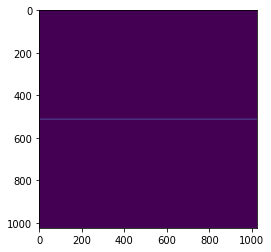

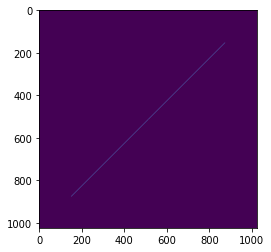

In [70]:
#test above function
#create map with 1 along center
N = 1024
beam_map = np.zeros((N,N))
beam_map[512,:] = np.ones(N)
rot_beam_map = rotate_map(beam_map, np.pi/4.)
plt.imshow(beam_map)
plt.show()
plt.imshow(rot_beam_map)
plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


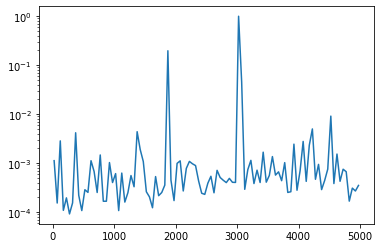

In [12]:
#define constants
perc_err = 0.05
ang = 30.*(np.pi/180.) #angle to rotate by in radians

#beam parameters
beam_sigma = 1.5*(1./60.)*(np.pi/180.)   #radians

#define relevant constants
N = 1024  # []: pixels in map
pixel_size = 0.25  # [arcmin/pixel]: size in arcmin of pixel
ell_max = 5000  # [ell]: maximum ell
delta_ell = 50  # [ell]: bin width for power spectra
scan_sp = 1.  # [deg/s]: scan speed of telescope
ell = np.arange(ell_max)  # [ell]: array of ell
tau = 10e-3
L = N*pixel_size

#make normal coordinate system
#define 2D model
##define 2D coordinate system in map space
x_1d = (np.arange(N)/N - 0.5)*L*np.pi/(180.*60.)
y_1d = np.copy(x_1d)
x,y = np.meshgrid(x_1d,y_1d)


#generate rotated beam and perpendicular
beam_gaussian = np.exp(-0.5*(x/beam_sigma)**2. -0.5*(y/beam_sigma)**2.)
exp_decay = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*np.pi/180.))
exp_decay_meas = np.exp(-np.sqrt(x**2.)/(scan_sp*tau*np.pi/180.*(1-perc_err)))

#take fft along horizontal
exp_decay_fft = np.zeros((N,N),dtype=complex)
exp_decay_meas_fft = np.zeros((N,N),dtype=complex)
for row in range(N):
    exp_decay_fft[row,:] = np.fft.fftshift(np.fft.fft(exp_decay[row,:]))
    exp_decay_meas_fft[row,:] = np.fft.fftshift(np.fft.fft(exp_decay_meas[row,:]))

#beam fft
beam_gaussian_fft = np.fft.fftshift(np.fft.fft2(beam_gaussian))
    
#rotate fft's
exp_decay_rot_para_fft = rotate_map(exp_decay_fft, ang)
exp_decay_rot_perp_fft = rotate_map(exp_decay_fft, ang+np.pi/2.)
exp_decay_rot_para_meas_fft = rotate_map(exp_decay_meas_fft, ang)
exp_decay_rot_perp_meas_fft = rotate_map(exp_decay_meas_fft, ang+np.pi/2.)


exp_decay_rot_para = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_para_fft)))#*beam_gaussian_fft) ))
exp_decay_rot_perp = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_perp_fft)))#*beam_gaussian_fft) ))
exp_decay_rot_para_meas = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_para_meas_fft)))#*beam_gaussian_fft) ))
exp_decay_rot_perp_meas = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_perp_meas_fft)))#*beam_gaussian_fft) ))

#########################################archive####################################################

#exp_decay_rot_para = rotate_map(exp_decay, ang)
#exp_decay_rot_perp = rotate_map(exp_decay, ang+np.pi/2.)
#exp_decay_rot_meas_para = rotate_map(exp_decay_meas, ang)
#exp_decay_rot_meas_perp = rotate_map(exp_decay_meas, ang+np.pi/2.)

#convolve with beam
#beam_gaussian_fft = np.fft.fftshift(np.fft.fft2(beam_gaussian))
#exp_decay_rot_para_fft = np.fft.fftshift(np.fft.fft2(exp_decay_rot_para))
#exp_decay_rot_perp_fft = np.fft.fftshift(np.fft.fft2(exp_decay_rot_perp))
#exp_decay_rot_meas_para_fft = np.fft.fftshift(np.fft.fft2(exp_decay_rot_meas_para))
#exp_decay_rot_meas_perp_fft = np.fft.fftshift(np.fft.fft2(exp_decay_rot_meas_perp))

#exp_decay_rot_para = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_para_fft*beam_gaussian_fft)))
#exp_decay_rot_perp = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_perp_fft*beam_gaussian_fft)))
#exp_decay_rot_meas_para = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_meas_para_fft*beam_gaussian_fft)))
#exp_decay_rot_meas_perp = np.fft.fftshift(np.real(np.fft.ifft2(exp_decay_rot_meas_perp_fft*beam_gaussian_fft)))                      

#plt.imshow(np.real(np.log(exp_decay_rot_para_fft + 0.00000001)))
#plt.show()

##################################################################################################


#average the two contributions in map space
exp_decay_rot = (exp_decay_rot_para + exp_decay_rot_perp)/2.
exp_decay_rot_meas = (exp_decay_rot_para_meas + exp_decay_rot_perp_meas)/2.


#take fft and deconvolve gaussian beam
exp_decay_rot_fft = np.fft.fftshift(np.fft.fft2(exp_decay_rot))
exp_decay_rot_meas_fft = np.fft.fftshift(np.fft.fft2(exp_decay_rot_meas))
exp_decay_rot_res_fft = np.zeros((N,N),dtype=complex)

exp_decay_rot_res_fft = exp_decay_rot_fft / exp_decay_rot_meas_fft

#exp_decay_rot_res_fft[512,:] = exp_decay_rot_fft[512,:] / exp_decay_rot_meas_fft[512,:]
#for row in range(N):
#    exp_decay_rot_res_fft[row,:] = exp_decay_rot_fft[512,:] / exp_decay_rot_meas_fft[512,:]

#bin to 1D
maps_dict = {}
maps_dict['TT'] = exp_decay_rot_res_fft
binned_ell, binned_exp_decay_rot_res = bin_maps_to_1d(maps_dict, delta_ell=delta_ell, ell_max=ell_max, pix_size=pixel_size, N=N)

#normalize
binned_exp_decay_rot_res['TT'] = binned_exp_decay_rot_res['TT'] / np.max(binned_exp_decay_rot_res['TT'])

#plot
plt.semilogy(binned_ell, binned_exp_decay_rot_res['TT'])
plt.show()


### Archive

Smear Beam along x as scan direction by extending beam sigma by the characteristic lag in degrees (scan_speed*$\tau$)

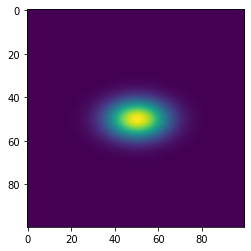

In [5]:
#define detector properties
det_tau = 15.e-3    #detector time constant in seconds
scan_sp = 1.    #scan speed of telescope in deg/s

#generate beam
N = 100    #number of pixels in beam map
pixel_size = 0.25    #pixel size in arcmin
L = N*pixel_size

x_1d = (np.arange(N)/N - 0.5)*L
y_1d = np.copy(x_1d)
x,y = np.meshgrid(x_1d,y_1d)

#lag in arcminutes due to detector tau
lag_scale = det_tau*scan_sp*(60.)

#smear beam sigma along scan direction (x)
nominal_sigma = 1.5    #normal beam sigma in ideal conditions in arcmin
sigma_x = nominal_sigma + lag_scale    #
sigma_y = nominal_sigma    #beam sigma along perpendicular
beam = np.exp(-0.5*((x/sigma_x)**2 + (y/sigma_y)**2   ))
plt.imshow(beam)

This lag is deprojected by some measurement uncertainty, which should be equivalent to subtracting the lag in the exponential sigma

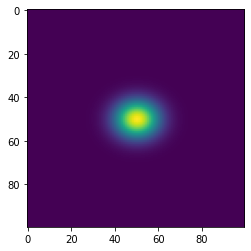

In [9]:
#percent level of uncertainty in measurement of detector tau
det_tau_unc = 0.3

#lag scale of measured detector tau in arcmin
lag_scale_measured = scan_sp*det_tau*(1-det_tau_unc)*(60.)

sigma_x_deproj = sigma_x - lag_scale_measured

#plot beam
beam_deproj = np.exp(-0.5*((x/sigma_x_deproj)**2 + (y/sigma_y)**2   ))
plt.imshow(beam_deproj)

## Compare 1D and 2D (Not the Residual Contamination Spectrum):

The finite response of a detector in the time domain is exponential decay ($a(t) = e^{-t/\tau}$), where t=0 is when the detector 'sees' the signal and $\tau$ is the detector's time constant. This can be represented in the spatial domain by introducing a scan speed as a unit conversion ($e^{-\theta/(s\tau)}$). Given this spatial representation of the detector response function, this can be transformed to $\ell$-space through fourier transforming

$$a(k) = \int _0^\infty e^{-\frac{\theta}{s\tau}} e^{-ik\theta}d\theta$$

This can be found to be a Lorentzian

$$a(k) = \frac{1}{\pi}\frac{k_0}{k_0^2+k^2}$$

and the relation between k and $\ell$ needs to be established

In the limit that a cross linking scan strategy is perfect, the exponential response function radially in 2D space. For a rastering scan strategy, the response function need only be applied along the direction of scan, only affecting the k-modes along the scan. This should mean that the 1D radial model should be equivalent to the 2D model applied to both axes, which can serve as a sanity check on the pipeline without the model. 

The fourier transform of the response function should look like a lowpass filter (normalized):

$$a(\ell) = \frac{1}{1 + \frac{\ell^2}{\ell_{cutoff}^2}}$$

where doing the above integral should pull out what $\ell_{cutoff}$ is in terms of s, $\tau$, and constants

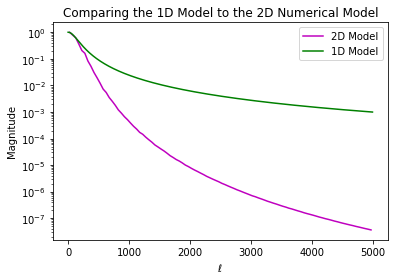

In [167]:
#define relevant constants
N = 1024  # []: pixels in map
pixel_size = 0.25  # [arcmin/pixel]: size in arcmin of pixel
ell_max = 5000  # [ell]: maximum ell
delta_ell = 50  # [ell]: bin width for power spectra
perc_err = 0.05  #[%]: percent the measure is off by
scan_sp = 1.  # [deg/s]: scan speed of telescope
tau = 200e-3  # [s]: time constant of detector
ell = np.arange(ell_max)  # [ell]: array of ell
L = N*pixel_size

#define 1D model
def lpf_tf_1d(ell, scan_sp, tau, N, pixel_size):
    import numpy as np
    
    ell_cutoff = 0.55/(scan_sp*tau*np.pi/180.)
    
    #theta_w = 0.5*N*pixel_size/60.*np.pi/180.
    #k_cutoff = scan_sp*tau*np.pi/180.
    lpf_tf = 1 / (1 + ell**2./ell_cutoff**2.)
    #lpf_tf = 0.5*( np.exp(-0.00001*theta_w/(k_cutoff)) + 2*np.cos(2*ell*theta_w) + np.exp(0.00001*theta_w/(k_cutoff)) )
    
    return lpf_tf

exp_decay_1d = lpf_tf_1d(ell, scan_sp, tau, N, L)
exp_decay_1d_deproj = lpf_tf_1d(ell, scan_sp*(1-perc_err), tau, N, L)
exp_decay_1d_res = exp_decay_1d#/exp_decay_1d_deproj

#define 2D model
##define 2D coordinate system in map space
x_1d = (np.arange(N)/N - 0.5)*L*np.pi/(180.*60.)
y_1d = np.copy(x_1d)
x,y = np.meshgrid(x_1d,y_1d)

r = np.sqrt(x**2. + y**2.)
exp_decay_2d = np.exp(-r/(scan_sp*tau*np.pi/180.))
exp_decay_2d_deproj = np.exp(-r/(scan_sp*tau*np.pi/180.*(1-perc_err)))


##fourier transform and bin to ell space
exp_decay_2d_fft = np.fft.fftshift(np.fft.fft2((exp_decay_2d)))
#exp_decay_2d_deproj_fft = np.fft.fftshift(np.fft.fft2((exp_decay_2d_deproj)))
maps_dict = {}
maps_dict['TT'] = exp_decay_2d_fft#/exp_decay_2d_deproj_fft
binned_ell, binned_exp_decay_2d = bin_maps_to_1d(maps_dict, delta_ell=delta_ell, ell_max=ell_max, pix_size=pixel_size, N=N)

#generate 1D radial $\ell$-space response function

#generate 2D x-scan $\ell$-space response function

#generate 2D y-scan $\ell$-space response function

#compare
plt.semilogy(binned_ell, binned_exp_decay_2d['TT']/np.max(binned_exp_decay_2d['TT']), color='m')
plt.semilogy(ell, exp_decay_1d_res, color='g')
plt.title('Comparing the 1D Model to the 2D Numerical Model')
plt.xlabel('$\ell$')
plt.ylabel('Magnitude')
plt.legend(['2D Model','1D Model'])
plt.show()

## Try Curve Fitting to get functional form

Parameter values are [5746.03526511]


Text(0, 0.5, 'Magnitude (arb)')

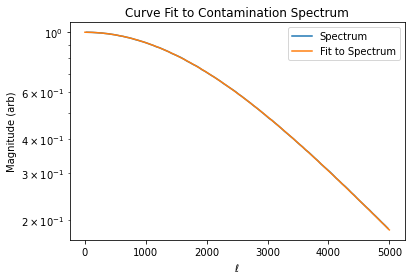

In [99]:
def lorenzian(x,xp):
    return ( 1  / ( 1. + (x/(xp))**2. )**3.)

import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = binned_ell
initial_guess = np.array([50])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(binned_exp_decay_2d['TT']/np.max(binned_exp_decay_2d['TT'])))
errors = sigma*np.ones(len(binned_exp_decay_2d['TT']))
curve_fit = optimization.curve_fit(lorenzian, ell_set, binned_exp_decay_2d['TT']/np.max(binned_exp_decay_2d['TT']), initial_guess, errors)

parameters = curve_fit[0]
tf_fit_r = lorenzian(ell,parameters[0])
print('Parameter values are ' + str(parameters))
plt.semilogy(binned_ell,binned_exp_decay_2d['TT']/np.max(binned_exp_decay_2d['TT']))
plt.semilogy(ell, tf_fit_r)
plt.title('Curve Fit to Contamination Spectrum')
plt.legend(['Spectrum','Fit to Spectrum'])
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')

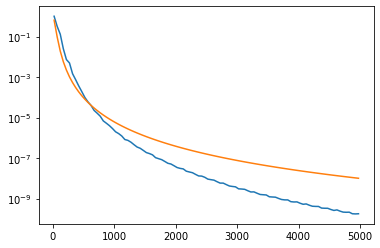

In [91]:
plt.semilogy(binned_ell,binned_exp_decay_2d['TT']/np.max(binned_exp_decay_2d['TT']))

x = binned_ell
plt.plot(x,(1/(1+(x/50.)**2))**2)



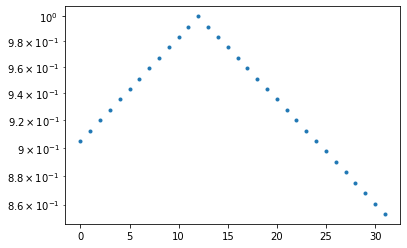

In [86]:
plt.semilogy(exp_decay_2d[512,500:532],'.')
plt.show()

Parameter values are [-0.00150062]


Text(0, 0.5, 'Magnitude (arb)')

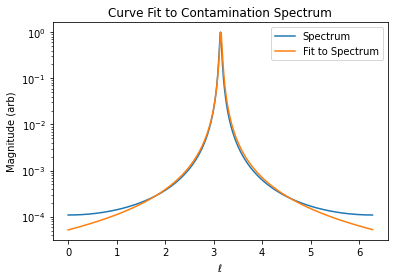

In [216]:
exp_1d_fft = np.fft.fftshift(np.fft.fft(exp_decay_2d[512,:]))
freqs_array = np.zeros(len(exp_1d_fft))

exp_1d_fft = np.sqrt(np.real(np.conj(exp_1d_fft)*exp_1d_fft))
k_array = np.arange(0,1024,1)
for i in range(len(freqs_array)):
    k = k_array[i]
    freqs_array[i] = 2*np.pi/N*k

import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = freqs_array
initial_guess = np.array([50])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(exp_1d_fft/np.max(exp_1d_fft)))
errors = sigma*np.ones(len(exp_1d_fft))
curve_fit = optimization.curve_fit(lorenzian, ell_set, exp_1d_fft/np.max(exp_1d_fft), initial_guess, errors)

parameters = curve_fit[0]
#tf_fit_r = lorenzian(freqs_array,parameters[0])
xp = .0225
x = freqs_array
tf_fit_r = (1 / (1 + ((x-3.15)/xp-0)**2.))
print('Parameter values are ' + str(parameters))
plt.semilogy(freqs_array,exp_1d_fft/np.max(exp_1d_fft))
plt.semilogy(freqs_array, tf_fit_r/np.max(tf_fit_r))
plt.title('Curve Fit to Contamination Spectrum')
plt.legend(['Spectrum','Fit to Spectrum'])
plt.xlabel('$\ell$')
plt.ylabel('Magnitude (arb)')

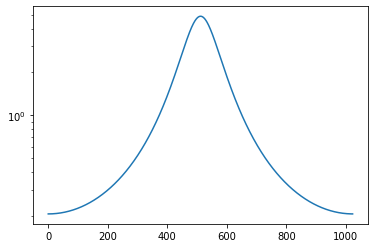

In [144]:
plt.semilogy(np.real(exp_1d_fft))

Basically, this assumes that taking an fft and binning the 2D exponential decay is correct and then backing out the conversion factor from k to $\ell$ in the flat space limit. The conversion factor between k modes and $\ell$ in this space seems to be k dependent. i.e. the conversion factor is different for k mode $\frac{1}{\omega*\tau*\pi/180}$ as opposed to the measured counterpart $\frac{1}{\omega*(1-\%_{err})*\tau*\pi/180}$. This means the analytical expression should find the functional form of this in order to correctly calculate the spectrum.

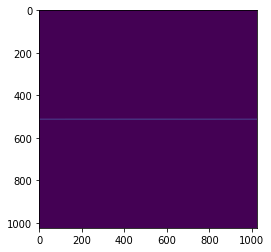

In [3]:


det_tau = 5.e-3   #detector tau in milliseconds
obs_freq = 90.    #observation frequency in GHz
scan_sp = 1.    #scan speed of telescope in deg/s
N = 1024    #number of pixels in map
pixel_size = 0.25/60.    #pixel size in deg
D_aper = 5.    #aperture diameter of telescope

#map_scan_fft = gen_scanx_dir_map(det_tau, obs_freq, scan_sp=scan_sp, N=N, pixel_size=pixel_size, D_aper=D_aper)

#relavant params: observing freq, scan speed in deg/s, N resolution of map, pixel size in deg, diameter of main aperture, det tau
ell_fac = 100. / 1. #conversion factor from deg to ell
obs_lam = constants.c / (obs_freq*10**9)
diff_lim = ell_fac / (1.22*(obs_lam / D_aper) * (180. / constants.pi))
ell_cutoff = ell_fac / (scan_sp * det_tau)

ell_max = ell_fac / (pixel_size)
ell = np.linspace(-2500, 2500, N)

#create empty map
map_scan_fft = np.zeros((N,N))

## make a 1/f map, along a single direction to illustrate striping 
one_over_f_noise_level = 1.
one_overf_noise = 0
if (one_over_f_noise_level != 0): 
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) 
    X = np.outer(ones,inds) * pixel_size /60. ## angles relative to 1 degrees 
    kx = 2 * np.pi/(X+.01) ## 0.01 is a regularization factor
    oneoverf_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
    oneoverf_noise = np.fft.ifft2(oneoverf_noise * np.fft.fftshift(kx))* one_over_f_noise_level/pixel_size

#fill each row with lpf TF
for i in np.arange(N):

    #map_scan_fft[i][int(N/2):] = lpf_tf(ell[:int(N/2)], scan_sp, det_tau)
    #map_scan_fft[i][:int(N/2)] = lpf_tf(np.flip(ell[:int(N/2)],0), scan_sp, det_tau)
    if i == int(N/2):
        map_scan_fft[i][int(N/2):] = np.exp(-ell[:int(N/2)]*scan_sp*det_tau/100)
        #map_scan_fft[i][:] = np.exp(-ell*scan_sp*det_tau/100)
        map_scan_fft[i][:int(N/2)] = np.exp(-np.flip(ell[:int(N/2)])*scan_sp*det_tau/100)
    else:
        map_scan_fft[i][:] = np.zeros(N)


plt.imshow(map_scan_fft)
plt.show()

/home/ahryciuk/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


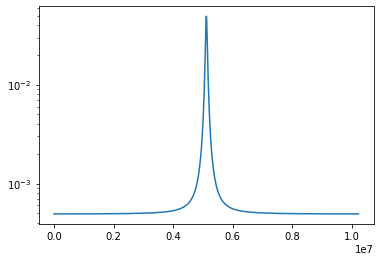

In [5]:
delta_t = 1e-4
time_array = np.array([i*delta_t for i in range(N)])
freq_array = np.array([i/delta_t for i in range(N)])
exp_time = np.exp(-time_array/det_tau)
exp_freq = np.fft.fftshift(np.fft.fft(exp_time))
exp_freq = exp_freq / np.sum(exp_freq)

plt.semilogy(freq_array,exp_freq)
plt.show()

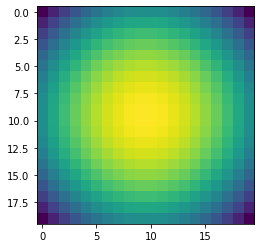

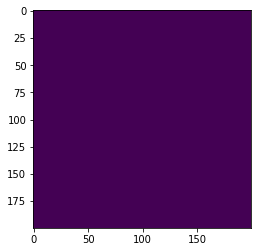

In [40]:
beam_map = make_2d_gaussian_beam(N, pixel_size, 1.4)

#map_scan_fft_fft = np.fft.fft2(np.fft.fftshift(map_scan_fft)) / np.sum(np.fft.fft2(np.fft.fftshift(map_scan_fft)))
beam_map_fft = np.fft.fft2(np.fft.fftshift(beam_map))
convolved_map_fft = beam_map_fft*map_scan_fft
convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(convolved_map_fft)))
plt.imshow(beam_map[int(N/2)-10:int(N/2)+10,int(N/2)-10:int(N/2)+10])
plt.show()

plt.imshow(convolved_map[int(N/2)-100:int(N/2)+100,int(N/2)-100:int(N/2)+100])
plt.show()

using concrete pixel lag to smear beam along scan

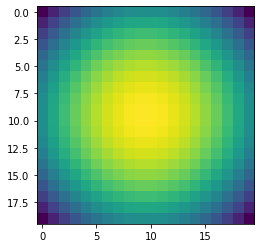

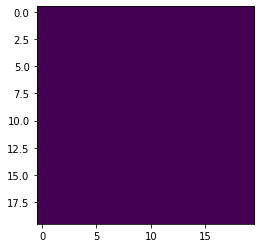

In [44]:
det_tau = 5.e-3   #detector tau in milliseconds
obs_freq = 90.    #observation frequency in GHz
scan_sp = 10.    #scan speed of telescope in deg/s
N = 1024    #number of pixels in map
pixel_size = 0.25/60.    #pixel size in deg
D_aper = 5.    #aperture diameter of telescope

#when generate detector sky maps, add a feature that lags the two pixel values along the scan direction by some amount
#lag even rows by +x and odd rows by -x
def lag_map_along_scan(det_map, tau_det, scan_sp=3., pix_size=0.25/60., leftright = 'right'):
    import numpy as np
    
    #scan speed is deg/sec, tau_det in milliseconds, pixel size is in deg
    num_pix_lag = int(scan_sp * tau_det / pix_size)
    #print(num_pix_lag)
    
    #lag all the 1's in the detector map by pixel amt
    #indices_to_lag = np.where(det_map == 1.)
    indices_to_lag = det_map.nonzero()
    col_inds = indices_to_lag[0]
    row_inds = indices_to_lag[1]
    
    lagged_beam_map = det_map.copy()
    
    if col_inds.any():
        for i in range(len(col_inds)):
            
            #store pixel value
            pixel_value = det_map[col_inds[i], row_inds[i]]
            
            #set map at unlagged position to zero
            lagged_beam_map[col_inds[i], row_inds[i]] = 0.
            
            if leftright == 'right':
                if row_inds[i]+num_pix_lag >= len(det_map[0,:]):
                    pass
                else:
                    lagged_beam_map[col_inds[i], row_inds[i] + num_pix_lag] = pixel_value
            elif leftright == 'left':
                lagged_beam_map[col_inds[i], row_inds[i] - num_pix_lag] = pixel_value
            else:
                print('define scan direction as left or right')
    else:
        pass
    
    return lagged_beam_map


lagged_beam_map = lag_map_along_scan(beam_map, det_tau,scan_sp=scan_sp, pix_size = pixel_size, leftright='right')

plt.imshow(beam_map[int(N/2)-10:int(N/2)+10,int(N/2)-10:int(N/2)+10])
plt.show()
plt.imshow(lagged_beam_map[int(N/2)-10:int(N/2)+10,int(N/2)-10:int(N/2)+10])
plt.show()

In [30]:
a = np.array([[0,1],[0,0]])
a.nonzero()

(array([0]), array([1]))

In [ ]:
#check the numbering scheme by plotting parts of rhombuses
#start with rows and make sure the bonpad pairs are attached to the detectors such that the detectors closest to the module
#are attached to the leftmost bondpad pairs and towards the right as the pixels get farther away

import matplotlib.pyplot as plt

#map parameters
pixel_size = 0.25/60.    #deg
N = 200    #number of pixels to a side
det_map = np.zeros((N,N))

#use the rhom_layout_dict to index the det_dict to pull out columns
#det_list_to_plot = rhom_layout_dict[2][150][11]

x_list = []
y_list = []

#for readout_col in range(12):
#    det_list_to_plot = rhom_layout_dict[2][90][readout_col]
det_list_to_plot = rhom_layout_dict[0][150][5]
for det in det_list_to_plot:
    i = np.where(det_list_to_plot == det)
    x = det_dict[90][det]['x']    #in degrees
    y = det_dict[90][det]['y']    #in degrees

    pix_x = int(N/2. + x/pixel_size)
    pix_y = int(N/2. + y/pixel_size)


    x_list.append(pix_x)
    y_list.append(pix_y)

    det_map[pix_x,pix_y] = 100.
    #plt.text(x_list[-1],y_list[-1],det,size=16)
    #plt.text(pix_x, pix_y, det, size=8, color='white')

#plt.imshow(det_map[int(N/2)-70:int(N/2)+70,int(N/2)-70:int(N/2)+70])
plt.imshow(det_map)
#plt.scatter(x_list, y_list)
#plt.savefig("Rhombus1.png",bbox_inches = 'tight')
plt.show()